# Redes Neurais - Aula 1

In [2]:
import torch
import fastai
from fastai import *
from fastai.vision import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
fastai.__version__

'1.0.25.dev0'

In [4]:
torch.manual_seed(17);
use_gpu = torch.cuda.is_available();use_gpu

True

## O Problema

In [5]:
path = untar_data(URLs.MNIST)

In [13]:
def show_label(number = 7):
    il = ImageItemList.from_folder(path/f'training/{number}')
    lbls = np.empty(il.items.size, dtype=np.int)
    lbls[:]=number
    ImageDataBunch.from_lists(path, fnames=il.items, labels =lbls).show_batch(rows=4, figsize=(9,9))
    

### Como fazer uma função que reconheça os números escritos à mão?

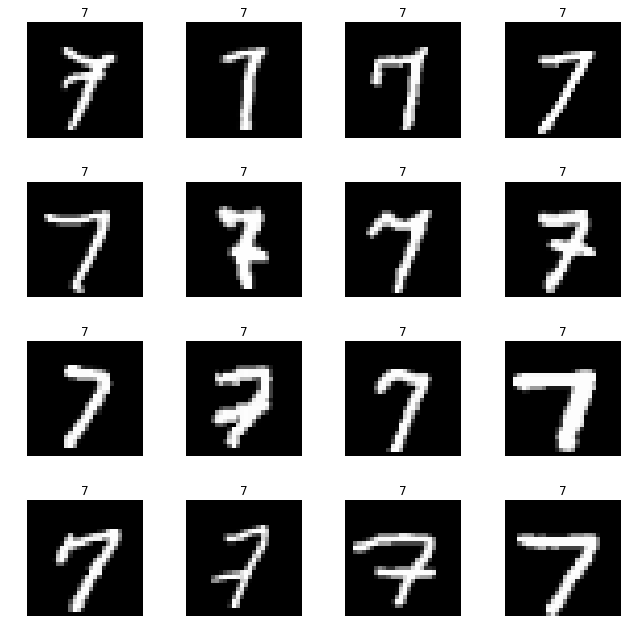

In [14]:
show_label(7)

![xkcd](tasks.png)

### Redes Neurais __aprendem__ extrair as features importantes diretamente dos dados.

### Teorema da aproximação universal: <font color=darkblue>Uma rede neural pode aproximar qualquer função contínua em $\small{R^n}$</font>

## Exemplo mais simples: Regressão Linear

Baseado no curso Fast.ai de Jeremy Howard

### Imagine que nos é dado o conjunto de dados abaixo:

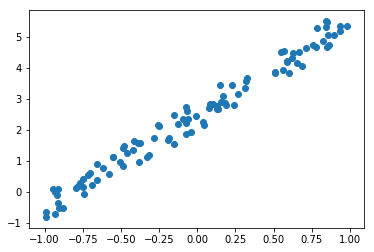

In [15]:
w_y = torch.tensor([3.,2])
def getLinearDataset(w_y):
    n = 100
    x = torch.ones(n,2)
    x[:,0].uniform_(-1., 1.)
    y = x@w_y + torch.rand(n)
    return (x, y[:None])
X, Y = getLinearDataset(w_y)
plt.scatter(X[:,0], Y)

### Queremos achar a função (modelo) que melhor prediz $\hat{y}$ para um novo $x$ dado

In [39]:
%%latex
$$\\\hat{y} = a\:x + b\\$$
Portanto, se tivermos $X=\{x1, x2, \dots x_m\}$, temos:
$$\\\hat{y_1} = a\:x_1 + b\\$$
$$\\\hat{y_2} = a\:x_2 + b\\\vdots$$
$$\\\hat{y_m} = a\:x_m + b\\$$

<IPython.core.display.Latex object>

### Para ser mais eficiente, usaremos matrizes:

$${x_i\:a} + b = \hat{y_i}$$

### Seja:

$$ \Theta = \begin{bmatrix}a \\ b \end{bmatrix} = \begin{bmatrix}\theta_0 \\ \theta_1 \end{bmatrix}$$


### Temos:
    
$$ \sum_{j=0}^{1}x_{i,j}\:\theta_j = \hat{y_i}:\: x_{i,0}=1 $$    

![Linear](linear.png)

$$[1|X]\:\Theta = \hat{Y} $$

$$ \begin{bmatrix}1 & x_{1,1}\\ \vdots & \vdots\\ 1 & x_{m,1}\end{bmatrix}_{m\times 2}  \begin{bmatrix}\theta_0 \\ \theta_1 \end{bmatrix}_{2\times1}=\begin{bmatrix}y_1\\ \vdots \\ y_m \end{bmatrix}_{m\times 1}$$

### Achar a função que melhor explica os dados é o mesmo que achar o melhor $\Theta$

 $ \Theta = \begin{bmatrix}\theta_0 \\ \theta_1 \end{bmatrix}=?$

$ \Theta_{inicial}:$

In [29]:
# initial weights
theta_inicial= torch.rand(2)*10-10; theta_inicial

tensor([-3.5806, -0.2339])

$$[1|X]\:\Theta_{inicial}=\hat{Y}$$

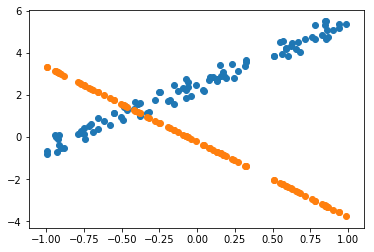

In [30]:
y_hat = X@theta_inicial
plt.scatter(X[:,0],Y)
plt.scatter(X[:,0],y_hat)

### Parece bem errado, como medimos o erro?

$$mse = \frac{(\hat{Y}-Y)^2}{|Y|}$$

In [31]:
def mse(y_hat, y): return ((y_hat-y)**2).mean(0)

### Plotando o erro

Baseado em https://nbviewer.jupyter.org/gist/joshfp/71c5b16b1d2adeca9e539beb76030325

In [32]:
from mpl_toolkits import mplot3d

In [33]:
def losses(a, b):
    theta = torch.Tensor([a, b])
    y_hat = X@theta
    return mse(y_hat, Y)
loss_wgts = np.vectorize(losses)

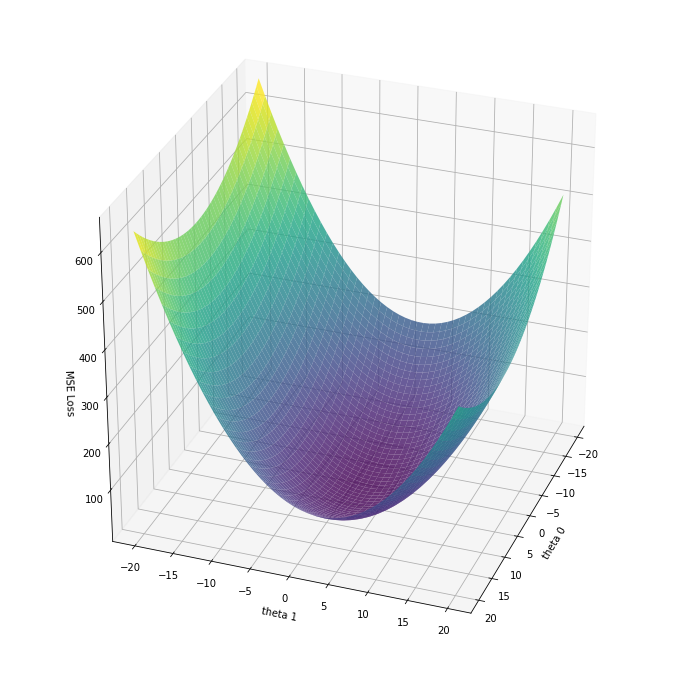

In [36]:
Theta0_range = np.linspace(-20, 20, 50)
Theta1_range = np.linspace(-20, 20, 50)
mesh = np.meshgrid(Theta0_range, Theta1_range)
loss_mesh = loss_wgts(*mesh)
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
ax.plot_surface(*mesh, loss_mesh, cmap='viridis', alpha=0.8)
ax.set_xlabel('theta 0'); ax.set_ylabel('theta 1'); ax.set_zlabel('MSE Loss')
ax.view_init(30, 20)

### Queremos encontrar o mínimo global dessa função

## Gradient Descent: Nosso Otimizador

In [40]:
def update(w):
    y_hat = X@w
    loss = mse(Y, y_hat)
    prev_wgts = w.data.clone()   
    loss.backward()
    with torch.no_grad():
        w -= lr * w.grad
        w.grad.zero_()
    return prev_wgts, loss.item()

In [41]:
def train(w0):
    recorder = []
    w = torch.tensor(w0, requires_grad=True)
    for t in range(n_epochs): recorder.append(update(w))
    rec_wgts, rec_loss = [list(o) for o in zip(*recorder)]
    rec_wgts = torch.stack(rec_wgts)
    return rec_wgts, rec_loss

In [44]:
# hyper parameters
lr = 0.1
n_epochs = 100

# initial parameters (weights)
w0 = [-18., -18.]

rec_wgts, rec_loss = train(w0)

In [45]:
from matplotlib import animation
from matplotlib.gridspec import GridSpec
plt.rc('animation', html='html5')

In [46]:
fig = plt.figure(figsize=(14, 8))
gs = GridSpec(2, 2, width_ratios=[1, 2.5])

# plot ground truth & model
ax0 = fig.add_subplot(gs[0,0])
ax0.scatter(X[:,0], Y, c='orange', label='Ground truth')
ax0.set_ylim(-1, 6)
ax0.set_title('Ground truth & Model', fontsize=16)
line0, = ax0.plot([], [], label='Model')
ax0.legend(loc='lower right')

# plot loss 
ax1 = fig.add_subplot(gs[:,1], projection='3d')
ax1.set_title('Loss', fontsize=16, pad=20)
ax1.plot_surface(*mesh, loss_mesh, cmap='viridis', alpha=0.8)
ax1.plot3D([w_y[0]], [w_y[1]], [0], c='r', marker='x', markersize=10, 
           label='Global minimum', linewidth=0)
line1, = ax1.plot3D([], [], [], c='r', marker='o', alpha=0.4, label='loss')
ax1.set_xlabel(r'$\theta_0$'); ax1.set_ylabel(r'$\theta_1$'); ax1.set_zlabel('Loss')
ax1.view_init(30, 20)
ax1.legend()

# plot weights & loss
ax2 = fig.add_subplot(gs[1,0])
ax2.set_title('Parameters (Weights) & Loss', fontsize=16)
line2, = ax2.plot([],[], label=r'$\theta_0$')
line3, = ax2.plot([],[], label=r'$\theta_1$')
ax2.set_ylim(-20, 5)
ax2.set_xlim(0, n_epochs)
ax2.set_xlabel('epochs')
ax2.set_ylabel('parameters')
ax3 = ax2.twinx()
line4, = ax3.plot([],[], label='loss', c='r')
ax3.set_ylabel('loss')
ax3.set_ybound(0, 500)

ax2.legend((line2, line3, line4), (r'$\theta_0$', r'$\theta_1$', 'loss'), loc='center right')

ttl = fig.suptitle(f'lr: {lr} - Epoch: 0/{n_epochs}', fontsize=22)
fig.tight_layout()
fig.subplots_adjust(top=0.85)
plt.close()

def animate(i):
    line0.set_data(X[:,0].numpy(), (X@rec_wgts[i]).numpy())
    line1.set_data(rec_wgts[:i+1,0].numpy(), rec_wgts[:i+1,1].numpy())
    line1.set_3d_properties(rec_loss[:i+1])
    epochs = np.arange(i+1)
    line2.set_data(epochs, rec_wgts[:i+1, 0].numpy())
    line3.set_data(epochs, rec_wgts[:i+1, 1].numpy())
    line4.set_data(epochs, rec_loss[:i+1])
    ttl.set_text(f'lr: {lr} - Epoch: {i+1}/{n_epochs}')
    return line0, line1, line2, line3, line4, ttl

In [47]:
# hyper parameters
lr = 0.1
n_epochs = 100

# initial parameters (weights)
w0 = [-18., -18.]

rec_wgts, rec_loss = train(w0)
animation.FuncAnimation(fig, animate, range(n_epochs), interval=150)

In [48]:
# hyper parameters
lr = 0.7

rec_wgts, rec_loss = train(w0)
animation.FuncAnimation(fig, animate, range(n_epochs), interval=150)

In [49]:
# hyper parameters
lr = 0.99

rec_wgts, rec_loss = train(w0)
animation.FuncAnimation(fig, animate, range(n_epochs), interval=150)

In [50]:
# hyper parameters
lr = 1.01

rec_wgts, rec_loss = train(w0)
animation.FuncAnimation(fig, animate, range(n_epochs), interval=150)

### Até aqui, aprendemos:
- **modelo**: 
e.g. $[1|X]\Theta$
- **parâmetros** do modelo: e.g. $ \Theta = \begin{bmatrix}\theta_0 \\ \theta_1 \end{bmatrix}$
- **loss**: e.g. $\frac{(\hat{Y}-Y)^2}{|Y|}$
- **gradient descent**
- **otimizador**
- **learning rate**


### Em geral, temos problemas mais complexos do que o proposto

### Uma função de loss mais real

![landscape](loss_landscape.png)

## Perceptron: Um neurônio

![MIT 6.S191 Introduction to Deep Learning](perceptron.png)

Fonte: MIT 6.S191 Introduction to Deep Learning

**pesos** e **bias**: $\Theta = pesos \cup bias$

Normalmente, g(z) é ReLU: 

$$g(z) = max(0,z)$$

### Por que adcionamos uma não-linearidade?

![MIT 6.S191 Introduction to Deep Learning](ativacao.png)

![single layer neural network](single_layer.png)

![deep neural network](deep.png)

![nao linear](non_linear.png)

Fonte: playground.tensorflow.org

## MNIST: O Hello World de Redes Neurais

In [59]:
data = ImageDataBunch.from_folder(path, train="training", valid="testing")

In [61]:
len(data.train_ds.x)

60000

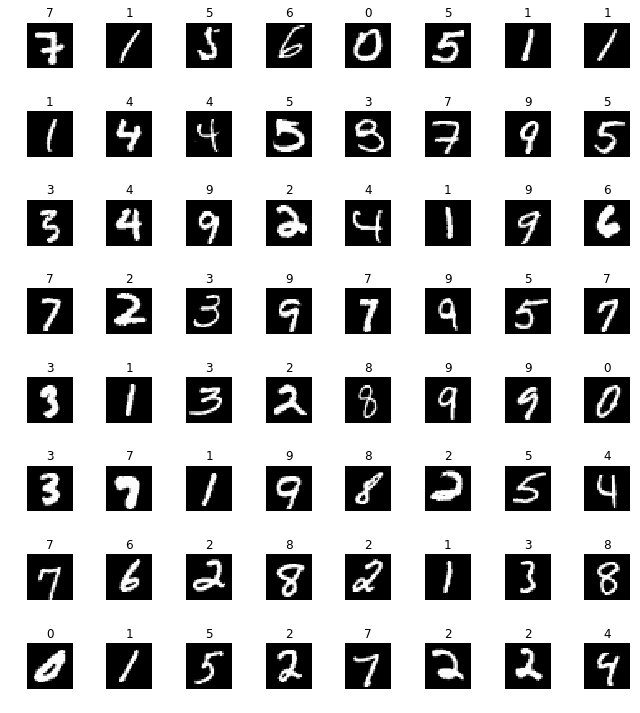

In [76]:
data.normalize()
data.show_batch()

### Model

In [1]:
import torch.nn as nn 

In [65]:
net = nn.Sequential(
    nn.Linear(28*28, 16),
    nn.ReLU(),
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.Linear(16, 10),
    nn.LogSoftmax()
).cuda()

Softmax implica que a saída serão número no range (0,1) que somam 1. 

In [74]:
loss_function=nn.NLLLoss()
metrics=[accuracy]
opt=optim.SGD(net.parameters(), lr=1e-1)

### Stochastic Gradient Descent = Minibatch Gradient Descent

In [79]:
data.train_dl.

ImageItemList (60000 items)
[PosixPath('/home/fredguth/.fastai/data/mnist_png/training/6/39004.png'), PosixPath('/home/fredguth/.fastai/data/mnist_png/training/6/11784.png'), PosixPath('/home/fredguth/.fastai/data/mnist_png/training/6/45686.png'), PosixPath('/home/fredguth/.fastai/data/mnist_png/training/6/7291.png'), PosixPath('/home/fredguth/.fastai/data/mnist_png/training/6/1688.png'), PosixPath('/home/fredguth/.fastai/data/mnist_png/training/6/30142.png'), PosixPath('/home/fredguth/.fastai/data/mnist_png/training/6/13373.png'), PosixPath('/home/fredguth/.fastai/data/mnist_png/training/6/10843.png'), PosixPath('/home/fredguth/.fastai/data/mnist_png/training/6/32549.png'), PosixPath('/home/fredguth/.fastai/data/mnist_png/training/6/14190.png'), PosixPath('/home/fredguth/.fastai/data/mnist_png/training/6/45623.png'), PosixPath('/home/fredguth/.fastai/data/mnist_png/training/6/45935.png'), PosixPath('/home/fredguth/.fastai/data/mnist_png/training/6/26697.png'), PosixPath('/home/fredgut

In [77]:
fit(model=net, data=data, epochs=5, loss_func=loss_function, opt=opt, metrics=metrics)

RuntimeError: size mismatch, m1: [5376 x 28], m2: [784 x 16] at /opt/conda/conda-bld/pytorch-nightly_1541668486622/work/aten/src/THC/generic/THCTensorMathBlas.cu:266

## End!